In [2]:
import os

import numpy as np
import pandas as pd

import pydicom
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import binary_crossentropy
from tensorflow.keras.utils import Sequence
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [3]:
INPUT_DIR = os.path.join("..", "input")

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "u-net-lung-segmentation-montgomery-shenzhen")
SEGMENTATION_MODEL = os.path.join(SEGMENTATION_DIR, "unet_lung_seg.hdf5")
SEGMENTATION_RESULT = "segmentation"
# SEGMENTATION_RESULT_TRAIN = os.path.join(SEGMENTATION_RESULT, "train")
# SEGMENTATION_RESULT_TEST = os.path.join(SEGMENTATION_RESULT, "test")
SEGMENTATION_RESULT_TRAIN = os.path.join(SEGMENTATION_RESULT, "N")
SEGMENTATION_RESULT_TEST = os.path.join(SEGMENTATION_RESULT, "P")

# RSNA_DIR = os.path.join(INPUT_DIR, "rsna-pneumonia-detection-challenge")
# RSNA_TRAIN_DIR = os.path.join(RSNA_DIR, "stage_2_train_images")
# RSNA_TEST_DIR = os.path.join(RSNA_DIR, "stage_2_test_images")
# RSNA_LABELS_FILE = os.path.join(RSNA_DIR, "stage_2_train_labels.csv")
# RSNA_CLASS_INFO_FILE = os.path.join(RSNA_DIR, "stage_2_detailed_class_info.csv")

DATA_DIR = os.path.join(".", "Data")
# RSNA_DIR = os.path.join(DATA_DIR, "rsna-pneumonia-detection-challenge")
RSNA_TRAIN_DIR = os.path.join(DATA_DIR, "N")
RSNA_TEST_DIR = os.path.join(DATA_DIR, "P")

In [4]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

segmentation_model = load_model(SEGMENTATION_MODEL, \
                                custom_objects={'dice_coef_loss': dice_coef_loss, \
                                                'dice_coef': dice_coef})

segmentation_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d_1[0][0]']               
                                )                                                           

In [5]:
def image_to_train(img):
    npy = img / 255
    npy = np.reshape(npy, npy.shape + (1,))
    npy = np.reshape(npy,(1,) + npy.shape)
    return npy

def train_to_image(npy):
    img = (npy[0,:, :, 0] * 255.).astype(np.uint8)
    return img

  0%|          | 0/426 [00:00<?, ?it/s]

(1, 512, 512, 1)
0 38
423 478
0 25
436 491


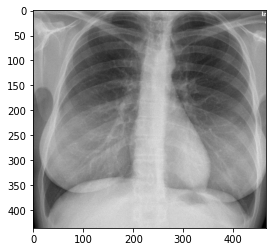

In [33]:
# offset is roughly 2.5% of 512
# CROP_OFFSET = 0/
CROP_OFFSET = 13

def segment_image(pid, img, save_to):
    img = cv2.resize(img, (512, 512))
    segm_ret = segmentation_model.predict(image_to_train(img), \
                                          verbose=0)
    print (segm_ret.shape)
    segm_s = np.squeeze(segm_ret)
    segm_s = np.where(segm_s > 0.5, 1, 0)
    
    up = left = 512
    down = right = 0

    for i in range(len(segm_s)):
        for j in range(len(segm_s[i])):
            if segm_s[i][j] == 1:
                up = min(up, i)
                down = max(down, i)
                left = min(left, j)
                right = max(right, j)

    # apply offset to cropping
    up = max(0, up-CROP_OFFSET)
    left = max(0, left-CROP_OFFSET)
    down = min(512, down+CROP_OFFSET)
    right = min(512, right+CROP_OFFSET)

    h_crop = down - up    
    w_crop = right - left

    cropped_image = img[up:up+h_crop, left:left+w_crop]
    # plt.imshow(cropped_image, cmap='gray')
    cv2.imwrite(os.path.join(save_to, "%s.jpg" % pid), cropped_image)


for filename in tqdm(glob(os.path.join(RSNA_TRAIN_DIR, "*.jpg"))):
    pid, fileext = os.path.splitext(os.path.basename(filename))
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    segment_image(pid, img, SEGMENTATION_RESULT_TRAIN)
    break

# for filename in tqdm(glob(os.path.join(RSNA_TEST_DIR, "*.jpg"))):
#     pid, fileext = os.path.splitext(os.path.basename(filename))
#     img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
#     segment_image(pid, img, SEGMENTATION_RESULT_TEST)

In [ ]:
!tar zcf segmentation.tgz --directory=segmentation .
!rm -rf segmentation